In [1]:
import h5py
import glob
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from sklearn.metrics import roc_curve, auc
import tensorflow.keras.backend as K
import qkeras
from qkeras import *

np.random.seed(42)
tf.random.set_seed(42)

## read data

In [ ]:
data_files = sorted(glob.glob('recon3D/recon3D_d*.parquet'))
labels_files = sorted(glob.glob('labels/labels_d*.parquet'))

chunk_size = 10
data_chunks = []
labels_chunks = []
n_files = 0

for i in range(0, len(data_files), chunk_size):
    data_chunk_files = data_files[i:i+chunk_size]
    labels_chunk_files = labels_files[i:i+chunk_size]
    
    data_chunk_list = []
    labels_chunk_list = []
    
    for rf, lf in zip(data_chunk_files, labels_chunk_files):
        d = pd.read_parquet(rf)
        l = pd.read_parquet(lf)
        
        data_chunk_list.append(d)
        labels_chunk_list.append(l[['y-local', 'pt']])
        
        n_files += 1
        print(f"Processed {n_files} files", end='\r')
        sys.stdout.flush()
    
    chunk_data_df = pd.concat(data_chunk_list, ignore_index=True)
    chunk_labels_df = pd.concat(labels_chunk_list, ignore_index=True)
    
    data_chunks.append(np.reshape(chunk_data_df.to_numpy(), (-1, 20, 13, 21)))
    labels_chunks.append(chunk_labels_df)

del data_chunk_list, labels_chunk_list, d, l, chunk_data_df, chunk_labels_df

## plot data

In [ ]:
n = 4
data = np.concatenate(data_chunks[:n], axis=0)
labels = pd.concat(labels_chunks[:n], ignore_index=True)

In [ ]:
for i in range(data[0].shape[0]):
    plt.figure(figsize=(4, 3))
    plt.imshow(data[0][i], aspect='auto', cmap='viridis')
    plt.title(f'Time slice {i+1}')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.colorbar(label='cluster charge')
    plt.tight_layout()
    plt.show()

In [ ]:
y0_range = [(-1, 1), (-8, -6), (6, 8)]
for r in y0_range:
    data_y0range = data[(labels['y-local'] > r[0]) & (labels['y-local'] < r[1])]
    labels_y0range = labels[(labels['y-local'] > r[0]) & (labels['y-local'] < r[1])]
    
    # take the last time slice, and sum over x to get y profile
    y_profile = data_y0range[:, -1, :, :].sum(axis = -1)
    
    y_profile_low_pos = y_profile[(labels_y0range['pt'] < 0.2) & (labels_y0range['pt'] > 0)]
    y_profile_low_neg = y_profile[(labels_y0range['pt'] > -0.2) & (labels_y0range['pt'] < 0)]
    y_profile_high = y_profile[(labels_y0range['pt'] > 0.2) | (labels_y0range['pt'] < -0.2)]
    
    y_profile_low_pos_mean = y_profile_low_pos.mean(axis = 0)
    y_profile_low_neg_mean = y_profile_low_neg.mean(axis = 0)
    y_profile_high_mean = y_profile_high.mean(axis = 0)
    
    edges = np.arange(len(y_profile_low_pos_mean) + 1)
    
    y_profile_low_pos_mean = np.concatenate(([0], y_profile_low_pos_mean))
    y_profile_low_neg_mean = np.concatenate(([0], y_profile_low_neg_mean))
    y_profile_high_mean = np.concatenate(([0], y_profile_high_mean))
    
    plt.figure(figsize=(4, 3))
    plt.step(edges, y_profile_low_pos_mean/np.sum(y_profile_low_pos_mean), where='post', label = 'Low pT (pos)', color='red')
    plt.step(edges, y_profile_low_neg_mean/np.sum(y_profile_low_neg_mean), where='post', label = 'Low pT (neg)', color='blue')
    plt.step(edges, y_profile_high_mean/np.sum(y_profile_high_mean), where='post', label = 'High pT', color='black')
    plt.title(f"Mean cluster shape ({r[0]}mm < y0 < {r[1]}mm)", size=10)
    #plt.ylim(0, max(y_profile_low_neg_mean)*1.25)
    plt.ylim(0, 0.35)
    plt.xlabel("y [pixels]")
    plt.ylabel("Mean cluster charge")
    plt.xticks(np.arange(0, len(y_profile_low_pos_mean) + 1, 2))
    plt.legend(fontsize=8)
    plt.show()

In [ ]:
del data, labels

## prepare training data

In [ ]:
for i in range(len(data_chunks)):
    data_chunks[i] = data_chunks[i][:, -1, :, :].sum(axis = -1)

n = 16
data = np.concatenate(data_chunks[:n], axis=0)
del data_chunks
labels = pd.concat(labels_chunks[:n], ignore_index=True)
del labels_chunks

In [ ]:
X = np.hstack((labels['y-local'].to_numpy().reshape(-1, 1), data))
del data

pt_truth = labels['pt'].to_numpy()
del labels

Y = np.zeros((pt_truth.size, 3))
Y[:, 2] = 1
Y[np.where((pt_truth >= 0) & (pt_truth < 0.2))] = [1, 0, 0]
Y[np.where((pt_truth < 0) & (pt_truth > -0.2))] = [0, 1, 0]

print(X.shape)
print(Y.shape)
print(np.sum(Y, axis=0))
print(pt_truth.shape)

In [ ]:
class0_idx = np.where(Y[:, 0] == 1)[0]
class1_idx = np.where(Y[:, 1] == 1)[0]
class2_idx = np.where(Y[:, 2] == 1)[0]

min_count = min(len(class0_idx), len(class1_idx), len(class2_idx))

chosen_class0 = np.random.choice(class0_idx, min_count, replace=False)
chosen_class1 = np.random.choice(class1_idx, min_count, replace=False)
chosen_class2 = np.random.choice(class2_idx, min_count, replace=False)

balanced_idx = np.concatenate([chosen_class0, chosen_class1, chosen_class2])

np.random.shuffle(balanced_idx)

X_balanced = X[balanced_idx]
Y_balanced = Y[balanced_idx]
pt_truth_balanced = pt_truth[balanced_idx]

all_indices = np.arange(Y.shape[0])
rest_idx = np.setdiff1d(all_indices, balanced_idx)

X_rest = X[rest_idx]
Y_rest = Y[rest_idx]
pt_truth_rest = pt_truth[rest_idx]

del X, Y, pt_truth

print(X_balanced.shape)
print(Y_balanced.shape)
print(np.sum(Y_balanced, axis=0))
print(pt_truth_balanced.shape)

print(X_rest.shape)
print(Y_rest.shape)
print(np.sum(Y_rest, axis=0))
print(pt_truth_rest.shape)

In [ ]:
train_ratio = 0.6
val_ratio = 0.05
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_balanced, Y_balanced, test_size = test_ratio, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)

pt_truth_train_val, pt_truth_test = train_test_split(pt_truth_balanced, test_size = test_ratio, random_state = 42)

X_test = np.concatenate((X_test, X_rest), axis=0)
Y_test = np.concatenate((Y_test, Y_rest), axis=0)
pt_truth_test = np.concatenate((pt_truth_test, pt_truth_rest), axis=0)

print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('Y_val   shape: ' + str(Y_val.shape))
print('Y_test  shape: ' + str(Y_test.shape))
print('pt_truth_test  shape: ' + str(pt_truth_test.shape))

del X_balanced, Y_balanced, pt_truth_balanced, X_rest, Y_rest, pt_truth_rest, X_train_val, Y_train_val, pt_truth_train_val

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('Y_train.npy', Y_train)
np.save('Y_val.npy', Y_val)
np.save('Y_test.npy', Y_test)
np.save('pt_truth_test.npy', pt_truth_test)

In [2]:
X_train = np.load('X_train.npy', mmap_mode='r')
X_val = np.load('X_val.npy', mmap_mode='r')
X_test = np.load('X_test.npy', mmap_mode='r')
Y_train = np.load('Y_train.npy', mmap_mode='r')
Y_val = np.load('Y_val.npy', mmap_mode='r')
Y_test = np.load('Y_test.npy', mmap_mode='r')
pt_truth_test = np.load('pt_truth_test.npy', mmap_mode='r')

print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('Y_val   shape: ' + str(Y_val.shape))
print('Y_test  shape: ' + str(Y_test.shape))
print('pt_truth_test  shape: ' + str(pt_truth_test.shape))

X_train shape: (366839, 14)
X_val   shape: (30570, 14)
X_test  shape: (7602073, 14)
Y_train shape: (366839, 3)
Y_val   shape: (30570, 3)
Y_test  shape: (7602073, 3)
pt_truth_test  shape: (7602073,)


## model

In [3]:
quantizer = quantized_bits(6, 0, alpha=1)
quantized_relu = 'quantized_relu(6, 0)'

x_input = keras.Input(shape=(14,), name='input')

x = QDense(128, use_bias=True, name='dense1', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x_input)
x = QActivation(quantized_relu, name='relu1')(x)
    
x = QDense(3, use_bias=True, name='dense2', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = layers.Softmax(name='softmax')(x)

model = keras.Model(x_input, x, name='model')

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 14)]              0         
                                                                 
 dense1 (QDense)             (None, 128)               1920      
                                                                 
 relu1 (QActivation)         (None, 128)               0         
                                                                 
 dense2 (QDense)             (None, 3)                 387       
                                                                 
 softmax (Softmax)           (None, 3)                 0         
                                                                 
Total params: 2307 (9.01 KB)
Trainable params: 2307 (9.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    epochs=100, batch_size=128)

Epoch 1/100
2866/2866 [==============================] - 2s 595us/step - loss: 0.7414 - accuracy: 0.6763 - val_loss: 0.6535 - val_accuracy: 0.7245
Epoch 2/100
2866/2866 [==============================] - 2s 577us/step - loss: 0.6255 - accuracy: 0.7343 - val_loss: 0.6163 - val_accuracy: 0.7395
Epoch 3/100
2866/2866 [==============================] - 2s 557us/step - loss: 0.6003 - accuracy: 0.7439 - val_loss: 0.5953 - val_accuracy: 0.7448
Epoch 4/100
2866/2866 [==============================] - 2s 549us/step - loss: 0.5864 - accuracy: 0.7493 - val_loss: 0.5851 - val_accuracy: 0.7509
Epoch 5/100
2866/2866 [==============================] - 2s 568us/step - loss: 0.5779 - accuracy: 0.7520 - val_loss: 0.5800 - val_accuracy: 0.7537
Epoch 6/100
2866/2866 [==============================] - 2s 565us/step - loss: 0.5722 - accuracy: 0.7543 - val_loss: 0.5782 - val_accuracy: 0.7507
Epoch 7/100
2866/2866 [==============================] - 2s 565us/step - loss: 0.5679 - accuracy: 0.7558 - val_loss: 0

Text(0, 0.5, 'Loss')

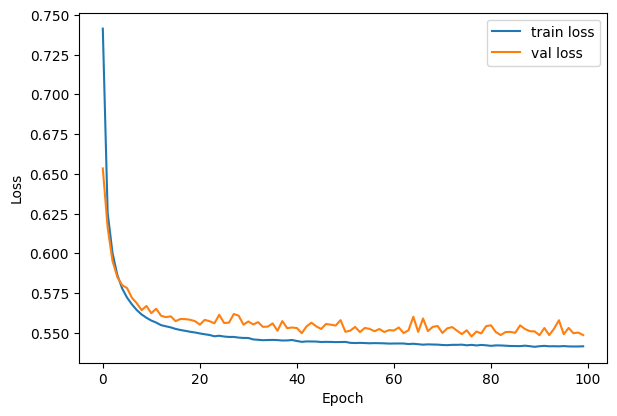

In [5]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [6]:
Y_pred = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))))

237565/237565 [==============================] - 56s 237us/step
Accuracy: 0.6108990271469374


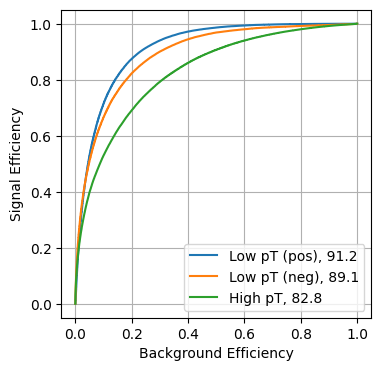

In [7]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0}, {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    #plt.semilogx()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.00001, 1)
    #plt.xlim(0.00001, 1)
    plt.grid(True)
    plt.legend(loc='best', fontsize=10)  
    
plt.figure(figsize=(4, 4))
plot_roc(Y_test, Y_pred, ['Low pT (pos)','Low pT (neg)','High pT'])

/var/folders/k_/3rw365c56w9f02q8nb4v2r4r0000gn/T/ipykernel_43596/2365849420.py:9: RuntimeWarning: invalid value encountered in divide
  proportions = class_001_counts / total_counts


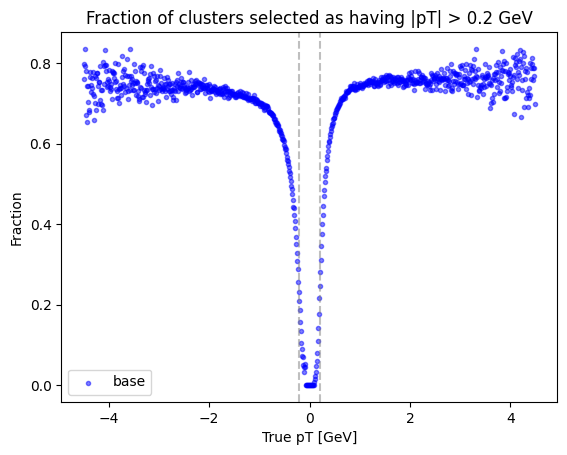

In [16]:
custom_bins = np.arange(-4.5, 4.5, 0.01)
bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])

indices_001 = np.argmax(Y_pred, axis=1) == 2

total_counts, _ = np.histogram(pt_truth_test, bins=custom_bins)
class_001_counts, _ = np.histogram(pt_truth_test[indices_001], bins=custom_bins)

proportions = class_001_counts / total_counts
proportions = np.nan_to_num(proportions)

plt.scatter(bin_centers, proportions, marker='.', label='base', alpha=0.5, color='blue')
plt.axvline(x=0.2, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=-0.2, color='grey', linestyle='--', alpha=0.5)

plt.legend(fontsize=10)
plt.xlabel('True pT [GeV]')
plt.ylabel('Fraction')
plt.title('Fraction of clusters selected as having |pT| > 0.2 GeV')
#plt.yscale('log')
#plt.ylim(0.01, 1)
plt.legend()
plt.show()